<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»
Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучить модель классифицировать комментарии на позитивные и негативные.

И построить модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
import pandas as pd
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet, stopwords

import nltk
import re
import torch
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import notebook

from sklearn import preprocessing
from sklearn import feature_selection 
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve


In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/toxic_comments.csv')
#df = pd.read_csv('/home/arteev/ds/DS_course/toxic_comments.csv')

#df = df.sample(120000).reset_index(drop=True)
display(df)
print()
print(df.info())
print()
print(df.describe())

,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0
...,...,...
159566,""":::::And for the second time of asking, when ...",0
159567,You should be ashamed of yourself \n\nThat is ...,0
159568,"Spitzer \n\nUmm, theres no actual article for ...",0
159569,And it looks like it was actually you who put ...,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB
None

               toxic
count  159571.000000
mean        0.101679
std         0.302226
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000


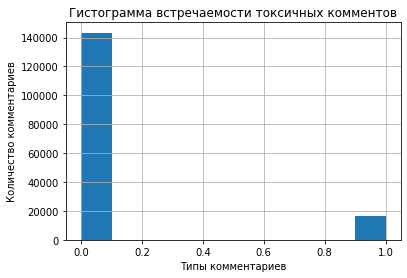

In [3]:
df['toxic'].hist()
plt.title("Гистограмма встречаемости токсичных комментов")

plt.ylabel("Количество комментариев")
plt.xlabel("Типы комментариев")
plt.show()

#### Вывод
- в тексте присутствует много лишних символов
- присутствует дисбаланс классов
- пропусков нет
- типы данных в порядке

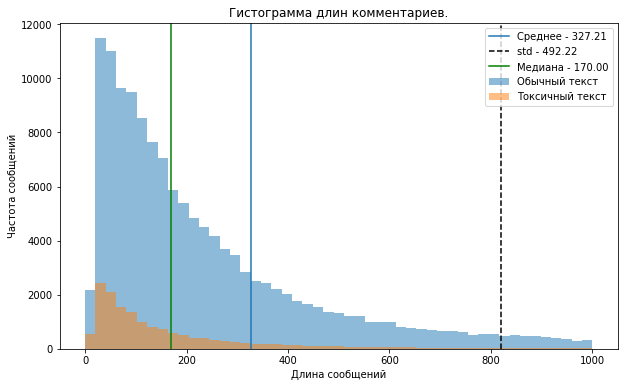

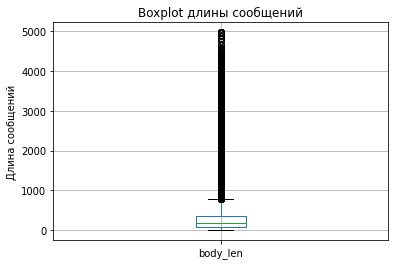

In [4]:
bins=np.linspace(0,1000,50)

df['body_len'] = df['text'].apply(lambda x: len(x)-x.count(" "))
plt.subplots(figsize=(10,6))

plt.hist(df[df['toxic']==0]['body_len'], bins, alpha=0.5, label='Обычный текст')
plt.hist(df[df['toxic']==1]['body_len'], bins, alpha=0.5, label='Токсичный текст')

plt.title('Гистограмма длин комментариев.')
plt.ylabel('Частота сообщений')
plt.xlabel('Длина сообщений')
plt.axvline(df['body_len'].mean(), label=("Среднее - {:.2f}".format(df['body_len'].mean())))
plt.axvline(df['body_len'].mean()+df['body_len'].std(), linestyle="--", color="k", label=("std - {:.2f}".format(df['body_len'].std())))
plt.axvline(df['body_len'].median(), linestyle="-", color="g", label=("Медиана - {:.2f}".format(df['body_len'].median())))

plt.legend(loc='upper right')
plt.show()

df.boxplot(column='body_len')
plt.title("Boxplot длины сообщений")
plt.ylabel("Длина сообщений")
plt.show()

#### Вывод
- токсичные комментарии отличаются по длине и количеству. Они более короткие и их меньше.

## Предобработка данных

#### Удалим текста длиной более 2000 символов

In [5]:
df = df.drop(df[df['body_len']>2000].index)
print(df.count())

text        156559
toxic       156559
body_len    156559
dtype: int64


In [6]:
nltk.download('stopwords')

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

wnl = WordNetLemmatizer()
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt')

def lemmatizer(text):
    return " ".join([wnl.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(text)])


def clear_text(text):
    return " ".join(re.sub(r'[^a-zA-Z]', ' ', text).split())

df['clear_text'] = df['text'].apply(clear_text)
df['lower_text'] = df['clear_text'].apply(lambda s: s.lower())
df['lemm_text'] = df['lower_text'].apply(lemmatizer)

display(df.head())

[nltk_data] Downloading package stopwords to /home/arteev/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/arteev/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/arteev/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /home/arteev/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,toxic,body_len,clear_text,lower_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,223,Explanation Why the edits made under my userna...,explanation why the edits made under my userna...,explanation why the edits make under my userna...
1,D'aww! He matches this background colour I'm s...,0,95,D aww He matches this background colour I m se...,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,192,Hey man I m really not trying to edit war It s...,hey man i m really not trying to edit war it s...,hey man i m really not try to edit war it s ju...
3,"""\nMore\nI can't make any real suggestions on ...",0,511,More I can t make any real suggestions on impr...,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,55,You sir are my hero Any chance you remember wh...,you sir are my hero any chance you remember wh...,you sir be my hero any chance you remember wha...


#### Чистка текста
- почистили текст от лишних символов
- привели к нижнему регистру
- лемматизировали текст
- удалили текста с длиной > 2000 символов

In [7]:
train, test = train_test_split(df, test_size=0.2, random_state=12345)
train = train.reset_index(drop=True)
test = test.reset_index(drop=True)

train_corpus = train['lemm_text'].values.astype('U')
test_corpus = test['lemm_text'].values.astype('U')


### Векторизация текста

In [8]:
stop_words = set(stopwords.words('english'))
tfidf_vectorizer = TfidfVectorizer( stop_words=stop_words) 

In [9]:
tfidf_vectorizer.fit(df['lemm_text'].values.astype('U'))

TfidfVectorizer(stop_words={'a', 'about', 'above', 'after', 'again', 'against',
                            'ain', 'all', 'am', 'an', 'and', 'any', 'are',
                            'aren', "aren't", 'as', 'at', 'be', 'because',
                            'been', 'before', 'being', 'below', 'between',
                            'both', 'but', 'by', 'can', 'couldn', "couldn't", ...})

In [10]:
train_features =  tfidf_vectorizer.transform(train_corpus)
test_features = tfidf_vectorizer.transform(test_corpus)

In [11]:
print(train_features.shape, test_features.shape)

(125247, 135663) (31312, 135663)


In [12]:
train_target = train['toxic']
test_target = test['toxic']

#### Итог векторизации
- разделили датасет на train и test
- инициализировали модель векторизации TF-IDF с удалением стоп слов
- преобразовали тексты в векторы

In [13]:
def calc_scores(true, predict):
    scores_dict = {}
    scores_dict['f1'] = f1_score(true, predict)
    scores_dict['precis'] = precision_score(true, predict)
    scores_dict['recall'] = recall_score(true, predict)
    scores_dict['roc_auc'] = roc_auc_score(true, predict)
    return scores_dict

def print_scores(scores_dict):
    print("   F1_score  {:.2f}".format(scores_dict['f1']))
    print("   Precision  {:.2f}".format(scores_dict['precis']))
    print("   Recall {:.2f}".format(scores_dict['recall']))
    print("   ROC-AUC {:.2f}".format(scores_dict['roc_auc']))
    
def predict_and_score(features, target):
    predictions = model.predict(features)

    scores = calc_scores(target, predictions)        
    print_scores(scores)

## Обучение
Обучим следующие модели  LogisticRegression, LinearSVC, DecisionTree

In [14]:
%%time

model = LogisticRegression(random_state=12345, max_iter=1000)
model.fit(train_features, train_target)

predicted_probabilities = model.predict_proba(train_features)


probabilities_once = predicted_probabilities[:, 1]
max_f1 = 0
scores = {}
f1_list = []
for threashold in np.arange(0.1, 0.3, 0.02):
    predicted_valid = probabilities_once>threashold
    f1 = f1_score(train_target, predicted_valid)
    f1_list.append(f1)
    
    if f1 > max_f1:
        max_f1 = f1
        best_treashold = threashold
        scores = calc_scores(train_target, predicted_valid)

print("LogisticRegression")
print("Best threshold ", best_treashold)       
print_scores(scores)

print()
print("Predict with best threshold")
predicted_probabilities = model.predict_proba(test_features)

probabilities_once = predicted_probabilities[:, 1]
predictions = probabilities_once>best_treashold

scores = calc_scores(test_target, predictions)        
print_scores(scores)

LogisticRegression
Best threshold  0.24000000000000002
   F1_score  0.83
   Precision  0.83
   Recall 0.83
   ROC-AUC 0.91

Predict with best threshold
   F1_score  0.78
   Precision  0.80
   Recall 0.76
   ROC-AUC 0.87
CPU times: user 1min 17s, sys: 3min 19s, total: 4min 37s
Wall time: 24.8 s


Text(0, 0.5, 'F1')

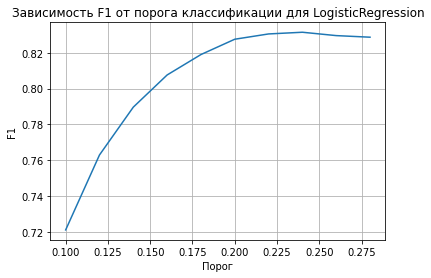

In [15]:
plt.plot(np.arange(0.1, 0.3, 0.02), f1_list)
plt.grid()
plt.title("Зависимость F1 от порога классификации для LogisticRegression")
plt.xlabel("Порог")
plt.ylabel("F1")

In [16]:
%%time

model = LogisticRegression(random_state=12345, max_iter=1000, class_weight='balanced')
model.fit(train_features, train_target)

steps = [('vectorizer', tfidf_vectorizer), ('model', model)]

pipeline = Pipeline(steps)
cross_score = cross_val_score(pipeline, train_corpus, train_target, cv=5, scoring='f1')

print("LogisticRegression cross_val score {:.2f}".format(cross_score.sum()/len(cross_score)))

LogisticRegression cross_val score 0.74
CPU times: user 5min 25s, sys: 13min 5s, total: 18min 30s
Wall time: 1min 58s


In [17]:
predictions = model.predict(test_features)

In [18]:
scores = calc_scores(test_target, predictions)        
print_scores(scores)

   F1_score  0.75
   Precision  0.67
   Recall 0.85
   ROC-AUC 0.90


#### Вывод

- LogisticRegression показала хороший score = 0.77

#### LinearSVC

In [19]:
%%time
model = LinearSVC(random_state=12345, class_weight='balanced')
model.fit(train_features, train_target)

print("LinearSVC. Train scores")
predict_and_score(train_features, train_target)

LinearSVC. Train scores
   F1_score  0.91
   Precision  0.83
   Recall 0.99
   ROC-AUC 0.99
CPU times: user 3.36 s, sys: 24.5 ms, total: 3.39 s
Wall time: 3.39 s


In [20]:
print("LinearSVC. Test scores")

predict_and_score(test_features, test_target)

LinearSVC. Test scores
   F1_score  0.76
   Precision  0.70
   Recall 0.82
   ROC-AUC 0.89


#### Decision Tree

In [21]:
%%time

model = DecisionTreeClassifier(random_state=12345)
model.fit(train_features, train_target)

print("Decision Tree. Train scores")
predict_and_score(train_features, train_target)

Decision Tree. Train scores
   F1_score  1.00
   Precision  1.00
   Recall 1.00
   ROC-AUC 1.00
CPU times: user 4min 19s, sys: 0 ns, total: 4min 19s
Wall time: 4min 20s


In [22]:
print("Decision Tree. Test scores")
predict_and_score(test_features, test_target)

Decision Tree. Test scores
   F1_score  0.71
   Precision  0.73
   Recall 0.70
   ROC-AUC 0.84


## Выводы
- Лучший скор показала LogisticRegression 0.78, а лучшее время LinearSVC 3s с результатом 0.76
- DecisionTree обучается дольше всех и сильно переобучается, что видно на результате предсказания по train F1=1 и test F1=0.71
- Лемматизация занимает очень много времени и не дает хорошей прибавки к f1.


## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Модели обучены
- [x]  Значение метрики *F1* не меньше 0.75
- [x]  Выводы написаны